#Code for Uncurving texts and reading them

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM
from bresenham import bresenham
from scipy.interpolate import interp1d
import pytesseract
import Levenshtein as lev

merged_points = []

n1_splines = 6
n2_splines = 12

def divide_arc_length(X, Y, n):


    dx = np.diff(X)
    dy = np.diff(Y)

    # Calculate the arc length increments
    ds = np.sqrt(dx**2 + dy**2)

    s = np.concatenate(([0], np.cumsum(ds)))

    # Total arc length
    L = s[-1]
    Delta_L = L / n

    # Find the points x_i
    x_points = [X[0]]  # Start with the initial point

    for i in range(1, n):
        target_length = i * Delta_L

        # Interpolating the x value at the target arc length
        idx = np.searchsorted(s, target_length)
        x0, x1 = X[idx-1], X[idx]
        s0, s1 = s[idx-1], s[idx]

        # Linear interpolation for the x value at the target arc length
        x_interp = x0 + (target_length - s0) * (x1 - x0) / (s1 - s0)
        x_points.append(x_interp)

    x_points.append(X[-1])  # Include the endpoint

    return x_points

def reshape_array_with_interpolation(original_array, new_size, kind='linear'):

    # Original indices based on the original array size
    original_indices = np.linspace(0, len(original_array) - 1, len(original_array))

    # New indices for the desired output shape
    new_indices = np.linspace(0, len(original_array) - 1, new_size)

    # Use interpolation
    interpolation_function = interp1d(original_indices, original_array, kind=kind)

    # Interpolate to find new values
    new_array = interpolation_function(new_indices)

    return np.round(new_array)

def pad_binary_image_with_ones(image):
    # Get the original image dimensions
    original_height, original_width = image.shape

    # Create a new array of ones with double the dimensions of the original image
    new_height = 2 * original_height
    new_width = 2 * original_width
    padded_image = np.ones((new_height, new_width), dtype=image.dtype) + 254

    # Copy the original image into the center of the new array
    start_row = original_height // 2
    start_col = original_width // 2
    padded_image[start_row:start_row + original_height, start_col:start_col + original_width] = image

    return padded_image

def find_distance_d(X, y, X_new, y_hat, step):
    # Starting point for the distance d
    d = 0
    max_iterations = 1000  # Prevent infinite loops
    iteration = 0
    found = False

    # Increment d until all points are covered or max_iterations is reached
    while iteration < max_iterations and not found:
        # Create two functions shifted by d
        upper_function = y_hat + d
        lower_function = y_hat - d

        # Check if all y points are within the bounds
        all_points_covered = np.all([(y[i] <= upper_function[np.argmin(np.abs(X_new - X[i]))]) and
                                    (y[i] >= lower_function[np.argmin(np.abs(X_new - X[i]))]) for i in range(len(X_new))])

        if all_points_covered:
            found = True
        else:
            d += step  # Increment d
            iteration += 1

    return int(np.ceil(2*d))

def calculate_derivative(y_values):
    dy = np.zeros(y_values.shape)
    dy[0] = y_values[1] - y_values[0]  # Forward difference
    dy[-1] = y_values[-1] - y_values[-2]  # Backward difference
    dy[1:-1] = (y_values[2:] - y_values[:-2]) / 2  # Central difference
    return dy

def find_perpendicular_points(y_values, x_values, d):
    dy = calculate_derivative(y_values)
    perpendicular_points = []

    for i, (x, y) in enumerate(zip(x_values, y_values)):
        slope = dy[i]
        if slope != 0:
            perp_slope = -1 / slope
        else:
            perp_slope = np.inf

        if np.isinf(perp_slope):  # Vertical line
            points = [(round(x), round(y - d)), (round(x), round(y + d))]
        else:
            # y = mx + c form for perpendicular line
            c = y - perp_slope * x
            # Solve for points that are distance d away from (x, y)
            delta = d / np.sqrt(1 + perp_slope**2)
            x1, x2 = x + delta, x - delta
            y1, y2 = perp_slope * x1 + c, perp_slope * x2 + c
            points = [(round(x1), round(y1)), (round(x2), round(y2))]

        perpendicular_points.append(points)

    return perpendicular_points

def uncurve_text_tight(input_path, output_path, n_splines,show_plot,arc_equal=False):
    # Load image, grayscale it, Otsu's threshold
    image = input_path
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    global merged_points
    # Dilation & Erosion to fill holes inside the letters
    kernel = np.ones((3, 3), np.uint8)
    # thresh = cv2.erode(thresh, kernel, iterations=1)
    # thresh = cv2.dilate(thresh, kernel, iterations=1)

    threshold_value = 30  # Adjust as needed

    black_pixels = np.column_stack(np.where(thresh <= threshold_value))
    leftmost_x = np.min(black_pixels[:, 1]) - int(0.05*(np.max(black_pixels[:, 1]) - np.min(black_pixels[:, 1])))
    rightmost_x = np.max(black_pixels[:, 1]) + int(0.05*(np.max(black_pixels[:, 1]) - np.min(black_pixels[:, 1])))
    X = black_pixels[:, 1].reshape(-1, 1)
    y = black_pixels[:, 0]

    merged_points = list(zip(black_pixels[:, 1], black_pixels[:, 0]))
    #print(merged_points)


    gam = LinearGAM(n_splines = n_splines)
    gam.fit(X, y)

    if arc_equal!=True:
        X_new = np.linspace(leftmost_x, rightmost_x, num = rightmost_x - leftmost_x)
    else:
        # Generate a dense set of points for accurate arc length calculation
        X_dense = np.linspace(leftmost_x, rightmost_x, num = rightmost_x - leftmost_x)

        Y_dense = gam.predict(X_dense)

        #print(f'X_dense : {X_dense}')
        #print(f'Y_dense : {Y_dense}')

        # Interval and number of segments
        n = rightmost_x - leftmost_x  # Number of equal segments

        # Get the points dividing the arc length into equal segments
        X_new = divide_arc_length(X_dense, Y_dense, n)
        #print(f'X_new : {X_new}')

    # Create the offset necessary to un-curve the text
    y_hat = gam.predict(X_new)

    #print(f'Y_dense : {y_hat}')

    if(show_plot):
      # Plot the image with text curve overlay
      plt.imshow(thresh, cmap='gray')
      plt.plot(X_new, y_hat, color='red')
      plt.axis('off')
      plt.subplots_adjust(bottom = 0, left = 0, right = 1, top = 1)
      plt.show()



    # Calculate height of text
    d = find_distance_d(X, y, X_new, y_hat, step = 0.5)

    dewarp_image = np.zeros(((2*d+1), len(X_new)), dtype=np.uint8) + 255

    # Calculate perpendicular points
    perpendicular_points = find_perpendicular_points(y_hat, X_new, d)
    my_iter = 0

    for points in perpendicular_points:
        x1, y1, x2, y2 = [element for tup in points for element in tup]
        if y1 > y2:  # If y1 is below y2, swap them to ensure top-to-bottom interpolation
            y1, y2 = y2, y1
            x1, x2 = x2, x1
        # Extract pixel values
        bresenham_list = list(bresenham(x1, y1, x2, y2))
        # Extract pixel values, ensuring they are within the bounds of the image
        pixel_values = []
        for x, y in bresenham_list:
            pixel_values.append(thresh[y, x])
        dewarp_image[:, my_iter] = reshape_array_with_interpolation(np.array(pixel_values), (2*d+1), kind='linear')
        my_iter += 1

    if(show_plot):
      # Plot the original image
      plt.imshow(thresh, cmap='gray', extent=[0, thresh.shape[1], thresh.shape[0], 0])

      # Plot the y_hat line
      plt.plot(X_new, y_hat, color='red')

      # Plot perpendicular points
      for points in perpendicular_points:
        plt.plot([x[0] for x in points], [x[1] for x in points], color='blue', alpha=0.5)

      plt.axis('off')
      plt.subplots_adjust(bottom = 0, left = 0, right = 1, top = 1)
      plt.show()

      # Plot the final image
      plt.imshow(dewarp_image, cmap=plt.cm.gray)
      plt.axis('off')
      plt.subplots_adjust(bottom = 0, left = 0, right = 1, top = 1)
      plt.show()

    text = pytesseract.image_to_string(thresh)
    print(text)
    cv2.imwrite(output_path, dewarp_image)
    return text

#Installing necessary libraries

In [ ]:
!pip install pygam
!pip install bresenham
!pip install pytesseract
!pip install Levenshtein
!apt-get update
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install ultralytics
!pip install gTTS
!pip install paddleocr paddlepaddle

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

#Importing the necessary libraries

In [ ]:
import cv2
from PIL import Image
from IPython.display import Image
# import pytesseract
from matplotlib import pyplot as plt
import numpy as np
import os
import re
# from skimage.filters import threshold_multiotsu

# Declaring Paths

In [ ]:
image_path = "/content/drive/MyDrive/Dataset_Sad/yoyo3.jpg"
output_dir = "/content/drive/MyDrive/Temp_Saved_Images"
intermediate_path = ""

In [ ]:
import os
import shutil

def clear_directory(directory):
    if os.path.exists(directory):
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)  # Delete the file or link
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)  # Delete the folder
                print(f"Deleted: {file_path}")
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")
    else:
        print(f"The directory {directory} does not exist.")

# Specify the directory to clear
temp_dir = "/content/drive/MyDrive/Temp_Saved_Images"
clear_directory(temp_dir)


#Perspective Transform

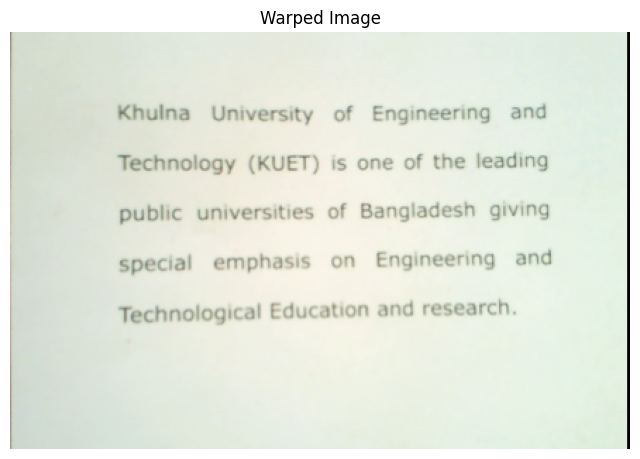

In [ ]:
# Required imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def perspective_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype="float32")
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

# Load and preprocess the image
# Ensure this path is accessible
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}. Check the file path.")

img = cv2.resize(img, (500, 300))
padding = 20
padded_image = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

def remove_padding(image, padding):
    height, width = image.shape[:2]
    return image[padding:height-padding, padding:width-padding]

# Utility to display images
def show_image(title, image):
    """Displays an image in Colab using matplotlib."""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Trackbar replacements
lower_thresh = 50  # Initial value
higher_thresh = 200  # Initial value

# Process the image
imgGray = cv2.cvtColor(padded_image, cv2.COLOR_BGR2GRAY)
imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 0)

# Canny edge detection
canny = cv2.Canny(imgBlur, lower_thresh, higher_thresh)
kernel = np.ones((5, 5), np.uint8)
imgDial = cv2.dilate(canny, kernel, iterations=2)
imgThreshold = cv2.erode(imgDial, kernel, iterations=1)
cnt = 0
# Find contours
contours, _ = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(largest_contour)

    # Get the convex hull
    hull = cv2.convexHull(largest_contour)
    peri = cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, 0.02 * peri, True)

    if len(approx) == 4:
        warped_image = perspective_transform(padded_image, approx.reshape(4, 2))
        top, bottom, left, right = 2, 2, 2, 2
        warped_image = warped_image[top:img.shape[0]-bottom, left:img.shape[1]-right]
        show_image("Warped Image", warped_image)
        save_path = os.path.join(output_dir, f"{cnt}.jpg")
        # warped_image = remove_padding(warped_image, padding)
        cv2.imwrite(save_path,warped_image)
        intermediate_path = save_path
        cnt = cnt + 1
    else:
        print(f"Approximating to a quadrilateral with {len(approx)} points.")

# Display results
# show_image("Thresholded Image", imgThreshold)

#Deskewing the entire image

In [ ]:
input_path =intermediate_path

Deskewed image saved to /content/drive/MyDrive/Temp_Saved_Images/0.jpg


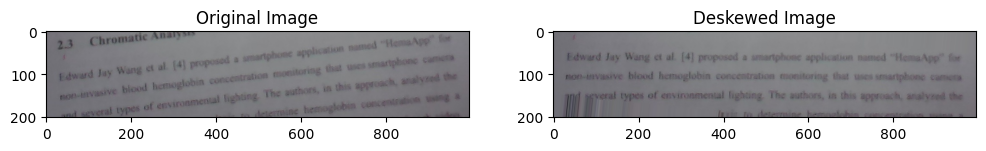

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def deskew_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply binary threshold
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Detect edges
    edges = cv2.Canny(binary, 50, 150)

    # Find lines using Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)

    # Calculate the skew angle
    angles = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            angles.append(angle)

    if angles:
        median_angle = np.median(angles)
    else:
        print("No lines detected, image may already be aligned.")
        cv2.imwrite(output_path, image)
        return

    # Correct the skew
    (h, w) = gray.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
    deskewed = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Save the deskewed image
    cv2.imwrite(output_path, deskewed)
    print(f"Deskewed image saved to {output_path}")

    # Display the original and deskewed image for comparison
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title("Deskewed Image")
    plt.imshow(cv2.cvtColor(deskewed, cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage
cnt = 0
save_path = os.path.join(output_dir, f"{cnt}.jpg")
intermediate_path = save_path
deskew_image(input_path, save_path)


# Code to check result of YOLO v11

In [ ]:
image_path = '/content/drive/MyDrive/Dataset_Sad/realtime1.jpg'

In [ ]:
image_path

'/content/drive/MyDrive/Dataset_Sad/realtime1.jpg'

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 384x640 1 Text, 1 Title, 325.5ms
Speed: 15.6ms preprocess, 325.5ms inference, 28.6ms postprocess per image at shape (1, 3, 384, 640)


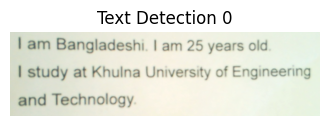

Cropped text regions saved in: /content/drive/MyDrive/Temp_Saved_Images


In [ ]:
import cv2
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Initialize model
model = YOLO("/content/drive/MyDrive/YOLOv11_weight/after_40_epoch_best.pt")  # Replace with your model path

# Run inference
results = model([image_path])

# Load the image
image = cv2.imread(image_path)
height, width, _ = image.shape

# Padding value (adjust as needed)
padding = 20

# Process results
for result in results:
    boxes = result.boxes  # Get detected boxes
    cls = boxes.cls.cpu().numpy()  # Get class indices
    xyxy = boxes.xyxy.cpu().numpy()  # Get bounding boxes in xyxy format

    # Loop through each detection
    for i, box in enumerate(xyxy):
        # Check if the class corresponds to "text"
        if cls[i] == 9:  # Replace with the class index for "text" in your model
            x1, y1, x2, y2 = map(int, box)  # Convert to integers

            # Apply padding and ensure coordinates are within bounds
            x1 = max(0, x1 - padding)
            y1 = max(0, y1 - padding)
            x2 = min(width, x2 + padding)
            y2 = min(height, y2 + padding)

            cropped = image[y1:y2, x1:x2]  # Crop the region

            # Save the cropped image
            save_path = os.path.join(output_dir, f"{i}.jpg")
            cv2.imwrite(save_path, cropped)
            intermediate_path = save_path

            # Display the cropped region inline
            cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4, 4))
            plt.imshow(cropped_rgb)
            plt.title(f"Text Detection {i}")
            plt.axis("off")
            plt.show()

print(f"Cropped text regions saved in: {output_dir}")


0: 384x640 1 Text, 1 Title, 135.3ms
Speed: 2.7ms preprocess, 135.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


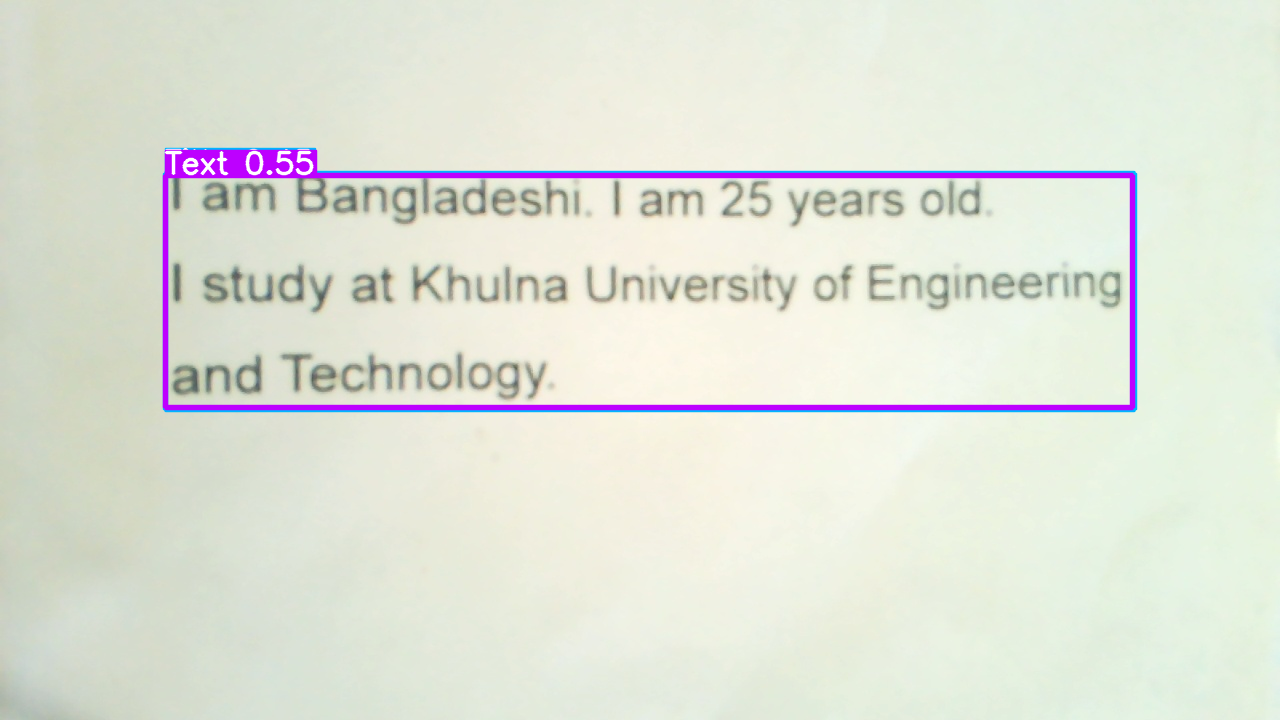

In [ ]:
from ultralytics import YOLO

# Run batched inference on a list of images
results = model([image_path])

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    probs = result.probs  # Probs object for classification outputs
    # result.show()  # display to screen
    result.show()

# Code to extract lines from an image path declaration

In [ ]:
image_path = '/content/drive/MyDrive/Input_images/realtime11.jpg'

In [ ]:
image_path

'/content/drive/MyDrive/Input_images/realtime11.jpg'

# Extraction of lines without watershed algorithm

In [ ]:
horizontal_projection = []

printing horizontal projection profile
[5610 5610 5610 ...    0    0    0]
1080
Saved cropped line 1 to /content/drive/MyDrive/Temp_Saved_Images/line_1.png
Saved cropped line 2 to /content/drive/MyDrive/Temp_Saved_Images/line_2.png
Saved cropped line 3 to /content/drive/MyDrive/Temp_Saved_Images/line_3.png
Detected Line Ranges (Start Row, End Row):
Line: 317 to 436
Line: 436 to 587
Line: 587 to 703


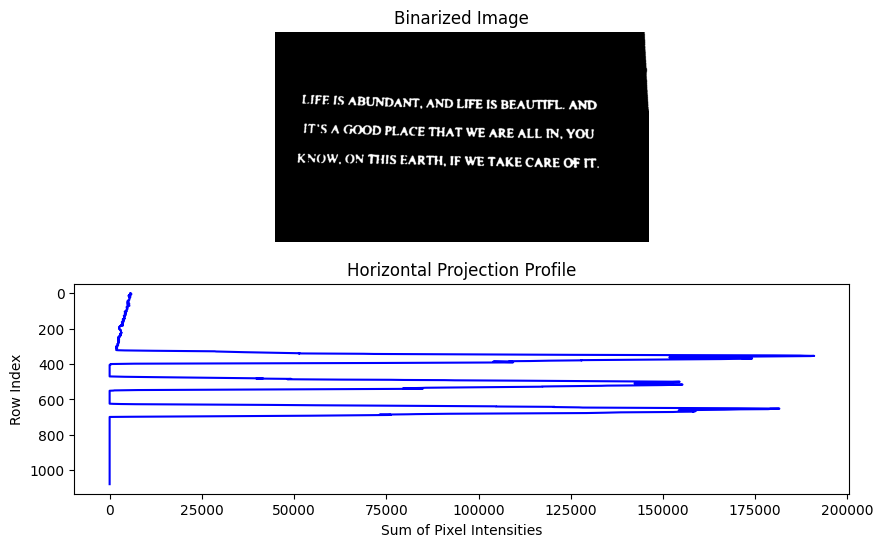

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def calculate_projection_profile_and_crop_lines(image_path, output_dir):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if image is loaded
    if image is None:
        print("Error: Unable to load image.")
        return

    # Binarize the image using Otsu's threshold
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Calculate the horizontal projection profile
    horizontal_projection = np.sum(binary_image, axis=1)

    print('printing horizontal projection profile')
    print(horizontal_projection)
    print(len(horizontal_projection))

    # Normalize the profile for better thresholding
    threshold = 0.1 * np.max(horizontal_projection)

    # Find row ranges for each line
    line_ranges = []
    is_in_line = False
    start_row = 0
    for row, value in enumerate(horizontal_projection):
        if value > threshold:
            if not is_in_line:
                start_row = row
                is_in_line = True
        else:
            if is_in_line:
                end_row = row
                line_ranges.append((start_row,end_row))
                is_in_line = False


    if(len(line_ranges)!=0):
      line_ranges[0] = (max(0,line_ranges[0][0]-10),line_ranges[0][1])
      line_ranges[-1] = (line_ranges[-1][0],min(image.shape[1],line_ranges[-1][1]+7))

    for i in range(1,len(line_ranges)):
        temp = (line_ranges[i-1][1] + line_ranges[i][0]) // 2
        line_ranges[i-1] = (line_ranges[i-1][0], temp)
        line_ranges[i] = (temp, line_ranges[i][1])

    # Crop and save each detected line
    cropped_lines = []
    for idx, (start, end) in enumerate(line_ranges):
        cropped_line = image[start:end, :]  # Crop the original grayscale image
        cropped_lines.append(cropped_line)
        # Save the cropped line as an image
        # print(cropped_line)
        output_path = f"{output_dir}/line_{idx + 1}.png"
        cv2.imwrite(output_path, cropped_line)
        print(f"Saved cropped line {idx + 1} to {output_path}")

    # Plot the projection profile and detected lines
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(binary_image, cmap='gray')
    plt.title("Binarized Image")
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.plot(horizontal_projection, range(binary_image.shape[0]), color='b')
    plt.gca().invert_yaxis()
    plt.title("Horizontal Projection Profile")
    plt.xlabel("Sum of Pixel Intensities")
    plt.ylabel("Row Index")

    # # Mark the detected line ranges
    # for start, end in line_ranges:
    #     plt.axhline(y=start, color='r', linestyle='--', xmin=0.05, xmax=0.95, label="Line Start")
    #     plt.axhline(y=end, color='g', linestyle='--', xmin=0.05, xmax=0.95, label="Line End")
    # plt.legend(["Projection Profile", "Line Start", "Line End"], loc="upper right")
    # plt.show()

    # Print detected line ranges
    print("Detected Line Ranges (Start Row, End Row):")
    for start, end in line_ranges:
        print(f"Line: {start} to {end}")

# Example usage
# Replace the paths below with your image path and output directory
calculate_projection_profile_and_crop_lines(image_path, output_dir)


In [ ]:
print(len(horizontal_projection))

0


# Using watershed for line extraction

Saved cropped line 1 to /content/drive/MyDrive/Temp_Saved_Images/line_1.png
Saved cropped line 2 to /content/drive/MyDrive/Temp_Saved_Images/line_2.png
Saved cropped line 3 to /content/drive/MyDrive/Temp_Saved_Images/line_3.png


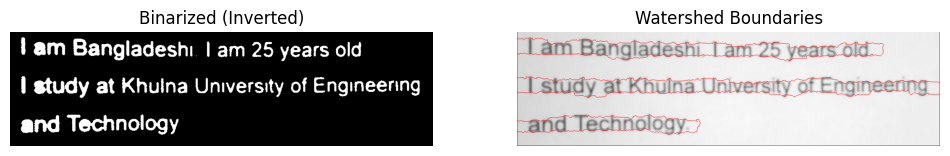

Watershed-based line segmentation complete!


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def calculate_lines_watershed(image_path, output_dir):
    # 1) Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Error: Unable to load image.")
        return

    # 2) Binarize (Otsu) and invert so text is white, background is black
    #    (Watershed often expects the foreground to be bright on dark background)
    _, binary_inv = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3) Morphological dilation to connect text within the same line
    #    Increase the kernel width if your lines are spaced out more
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80, 1))
    dilated = cv2.dilate(binary_inv, kernel, iterations=1)

    # 4) Distance transform to help separate regions
    dist_transform = cv2.distanceTransform(dilated, cv2.DIST_L2, 5)
    dist_max = dist_transform.max()

    # 5) Threshold the distance map to get sure foreground
    #    Adjust the factor (e.g., 0.3 * dist_max) if lines are merging or splitting incorrectly
    _, sure_fg = cv2.threshold(dist_transform, 0.3 * dist_max, 255, 0)
    sure_fg = np.uint8(sure_fg)

    # 6) Unknown region is what's left between sure foreground and original binarized area
    #    (the watershed will decide how to label these)
    unknown = cv2.subtract(dilated, sure_fg)

    # 7) Label the sure foreground
    num_markers, markers = cv2.connectedComponents(sure_fg)
    # Make sure the background is labeled as 1 instead of 0
    markers = markers + 1
    # Label the unknown region as 0 so that watershed can fill it
    markers[unknown == 255] = 0

    # 8) Convert original image to color so we can visualize watershed boundaries
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # 9) Apply the watershed algorithm
    markers = cv2.watershed(image_color, markers)
    # Mark watershed boundaries in red on the color image (for visualization)
    image_color[markers == -1] = [0, 0, 255]

    # 10) Each distinct marker > 1 now corresponds to a text “line” region
    #     We’ll find bounding boxes for each marker and save them
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    line_id = 1
    for marker_value in range(2, num_markers + 1):
        # Extract pixels belonging to the current marker
        mask = np.uint8(markers == marker_value)

        # If the mask is too small, skip it (noise or spurious region)
        if cv2.countNonZero(mask) < 10:
            continue

        # Find bounding box of the current marker
        x, y, w, h = cv2.boundingRect(mask)

        # Crop that region from the original grayscale image
        cropped_line = image[y:y+h, x:x+w]

        # Save the cropped line
        output_path = os.path.join(output_dir, f"line_{line_id}.png")
        cv2.imwrite(output_path, cropped_line)
        print(f"Saved cropped line {line_id} to {output_path}")
        line_id += 1

    # 11) (Optional) Show final results side by side
    #     Left: Original binarized (inverted) image
    #     Right: Watershed boundaries in red
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Binarized (Inverted)")
    plt.imshow(binary_inv, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Watershed Boundaries")
    plt.imshow(image_color[..., ::-1])  # Convert BGR to RGB for matplotlib
    plt.axis('off')
    plt.show()

    print("Watershed-based line segmentation complete!")

# Example usage:
calculate_lines_watershed(image_path, output_dir)


# Code for calling the uncurving cell

In [ ]:
output_dir

'/content/drive/MyDrive/Temp_Saved_Images'

In [ ]:
# Initialize an empty list to store matching file names
matching_files = []

# Define the regex pattern for matching file names
pattern = re.compile(r"line_\d+\.png$")

# Iterate through files in the directory
try:
    for file_name in os.listdir(output_dir):
        if pattern.search(file_name):
            matching_files.append(os.path.join(output_dir,file_name))

    # Print the result
    print("Matching files:", matching_files)

except FileNotFoundError:
    print(f"Directory not found: {output_dir}")
except Exception as e:
    print(f"An error occurred: {e}")

Matching files: ['/content/drive/MyDrive/Temp_Saved_Images/line_1.png', '/content/drive/MyDrive/Temp_Saved_Images/line_2.png', '/content/drive/MyDrive/Temp_Saved_Images/line_4.png']


In [ ]:
output_path = '/content/drive/MyDrive/Temporary/line.png'
final_path = '/content/drive/MyDrive/Temporary/line.png'
ocr_texts = []
for idx in matching_files:
  input_path = cv2.imread(idx)
  # predicted_text = uncurve_text_tight(input_path, output_path, n1_splines, 1,arc_equal=True)
  text = pytesseract.image_to_string(input_path)
  ocr_texts.append(text.strip())
  # os.remove(idx)

In [ ]:
ocr_texts

['1 am Bangladeshi. | am 25 years old',
 '| study at Khulna University of Engineering',
 'ana iecnnoiogy']

In [ ]:
from gtts import gTTS
import os
import time
from IPython.display import Audio

def merge_and_speak_text(texts):
    merged_text = ''
    final_text = ''

    for text in texts:
      merged_text += text + ' '

    # Final speech output
    for text in merged_text:
        if text==',':
          final_text += ' comma'
        else:
          final_text += text

    # print(final_text.strip())
    tts = gTTS(text=final_text, lang='en')
    tts.save("output.mp3")
    display(Audio("output.mp3", autoplay=True))

merge_and_speak_text(ocr_texts)

# Hand-Writing OCR

[2025/01/16 08:45:24] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

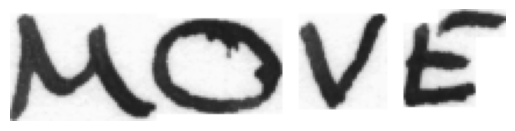

pyteserract detected text = 
No text detected in the image.


In [ ]:
from paddleocr import PaddleOCR
import cv2
from matplotlib import pyplot as plt

# Initialize the PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Load and display the image
image_path = '/content/a01-000u-00-00.png'
img = cv2.imread(image_path)

if img is None:
    print("Error: Image not found or could not be read. Check the file path.")
else:
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
    plt.axis('off')
    plt.show()

    # Perform OCR
    # result = ocr.ocr(image_path, cls=True)  # Provide the path directly
    text = pytesseract.image_to_string(image_path)
    print(f"pyteserract detected text = {text}")
    # Check if result contains any text
    if r > 0:
        print(result[0][0][1][0])  # Access the first detected text
    else:
        print("No text detected in the image.")


In [ ]:
# Open the file in read mode
file_path = "/content/words.txt"  # Replace with the path to your text file

try:
    with open(file_path, 'r') as file:
        for line_number, line in enumerate(file, start=1):
            if line_number > 18:
              print(f"Line {line_number}: {line.split()[-1]} {line.split()[1]}")
            if line_number > 50:
              break
except FileNotFoundError:
    print(f"The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Line 19: A ok
Line 20: MOVE ok
Line 21: to ok
Line 22: stop ok
Line 23: Mr. ok
Line 24: Gaitskell ok
Line 25: from ok
Line 26: nominating ok
Line 27: any ok
Line 28: more ok
Line 29: Labour ok
Line 30: life ok
Line 31: Peers ok
Line 32: is ok
Line 33: to ok
Line 34: be ok
Line 35: made ok
Line 36: at ok
Line 37: a ok
Line 38: meeting ok
Line 39: of ok
Line 40: Labour ok
Line 41: Ps err
Line 42: tomorrow err
Line 43: . err
Line 44: Mr. err
Line 45: Michael err
Line 46: Foot err
Line 47: has err
Line 48: put ok
Line 49: down ok
Line 50: a ok
Line 51: resolution ok


In [ ]:
import os
import cv2

# Define the root folder
root_folder = r"E:\Datasets\IAM_with_lables_words\iam_words\words"

# Open the file in read mode
file_path = "/content/words.txt"  # Replace with the path to your text file

# Traverse the directory structure
for root, dirs, files in os.walk(root_folder):
    for file in files:
        # Check if the file is an image based on its extension
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
            # Print the full path of the image
            image_path = file
            img = cv2.imread(image_path)
            cv2.imread(file)
            print(os.path.join(root, file))